In [1]:
import numpy as np
from numpy import cos, sin, pi
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib import rc, patches, colors

from compyle.utils import ArgumentParser
from compyle.api import declare

from pysph.base.kernels import QuinticSpline
from pysph.base.nnps import DomainManager
from pysph.base.utils import get_particle_array
from pysph.sph.equation import Equation, Group
from pysph.tools.sph_evaluator import SPHEvaluator

In [2]:
%matplotlib inline

rc('legend', fontsize='large')
rc('axes', grid=True, linewidth=1.5)
rc('axes.grid', which='both', axis='both')
rc('grid', linewidth=0.5, linestyle='--')
rc('xtick', direction='in', top=True)
rc('ytick', direction='in', right=True)
rc('lines', linewidth=2.0)

In [3]:
sizex = 1
sizey = 1

In [4]:
class SummationDensity(Equation):
    def initialize(self, d_idx, d_rho):
        d_rho[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_m, WIJ):
        d_rho[d_idx] += s_m[s_idx]*WIJ


class MonaghanClearyLaplacian(Equation):
    def __init__(self, dest, sources, nu):
        self.nu = nu
        super().__init__(dest, sources)

    def initialize(self, d_idx, d_d2f_dx2):
        d_d2f_dx2[d_idx] = 0.0

    def loop(self, d_idx, s_idx, d_rho, s_rho, s_m, d_d2f_dx2,
             R2IJ, EPS, DWIJ, d_f, s_f, XIJ):
        dw_dot_xij = DWIJ[0]*XIJ[0] + DWIJ[1]*XIJ[1] + DWIJ[2]*XIJ[2]

        Vj = s_m[s_idx] / (d_rho[d_idx] + s_rho[s_idx])

        tmp = Vj * 4 * self.nu * dw_dot_xij/(R2IJ + EPS)

        d_d2f_dx2[d_idx] += tmp * (d_f[d_idx] - s_f[s_idx])

In [5]:
def create_domain(lx, ly):
    return DomainManager(xmin=-lx, xmax=lx, ymin=-ly, ymax=ly,
                         periodic_in_x=True, periodic_in_y=True)


def create_particles(dx, perturb=0.1):
    dim = 2
    _x = np.arange(-sizex+dx/2, sizex, dx)
    _y = np.arange(-sizey+dx/2, sizey, dx)
    x, y = np.meshgrid(_x, _y)

    m = dx**dim
    hdx = 1.2
    h = hdx * dx

    if perturb > 0.0:
        np.random.seed(1234)
        x += np.random.random(x.shape) * perturb * dx
        y += np.random.random(y.shape) * perturb * dx

    fluid = get_particle_array(name='fluid', x=x, y=y, h=h, m=m, rho=1.0)

    props = ['f', 'f_approx', 'd2f_dx2', 'laplace_exact', 'f_exact']
    for prop in props:
        fluid.add_property(prop)
    fluid.add_property('m_mat', stride=9)
    fluid.add_property('gradf', stride=3)
    return fluid


def create_equations(fluid, kernel):
    eqns = []
    eqns.append(Group(
        equations=[SummationDensity(fluid.name, [fluid.name])], update_nnps=True
    ))
    eqns.append(Group(
        equations=[MonaghanClearyLaplacian(fluid.name, [fluid.name], nu=1.0)]
    ))
    domain_manager = create_domain(lx=sizex, ly=sizey)
    sph_eval = SPHEvaluator(
        arrays=[fluid], equations=eqns, dim=2,
        kernel=kernel, domain_manager=domain_manager
    )
    return sph_eval

In [6]:
def compute_approximation(dx=0.05, perturb=0.0):
    kernel = QuinticSpline(dim=2)
    fluid = create_particles(dx, perturb)

    x, y = fluid.x, fluid.y
    f_exact = sin(2*pi*(x+y))
    dfdx_exact = -2*pi * cos(2*pi * (x+y))
    dfdy_exact = -2*pi * cos(2*pi * (x+y))


    d2fdx2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    d2fdy2_exact = -(2*pi)**2 * sin(2*pi * (x+y))
    laplace_exact = d2fdx2_exact + d2fdy2_exact

    fluid.f[:] = f_exact
    fluid.f_exact[:] = f_exact
    fluid.laplace_exact = laplace_exact

    sph_eval = create_equations(fluid, kernel)
    sph_eval.update()
    sph_eval.evaluate()
    lap_err = np.sum(np.abs(fluid.d2f_dx2 - laplace_exact)) / len(fluid.x)
    return fluid, lap_err
    

def plot(fluid):
    plt.scatter(fluid.x, fluid.y, c=fluid.d2f_dx2, s=4, cmap='jet')
    plt.title("Laplacian approximation")
    plt.colorbar()
    plt.show()
    
    plt.scatter(fluid.x, fluid.y, c=fluid.laplace_exact, s=4, cmap='jet')
    plt.title("Laplacian exact")
    plt.colorbar()
    plt.show()
    
    plt.scatter(fluid.x, fluid.y, c=np.abs(fluid.laplace_exact-fluid.d2f_dx2), s=1, cmap='jet')
    plt.title("Error in approximation")
    plt.colorbar()
    plt.show()

In [7]:
fluid, lap_err = compute_approximation(dx=0.02, perturb=0.0001)

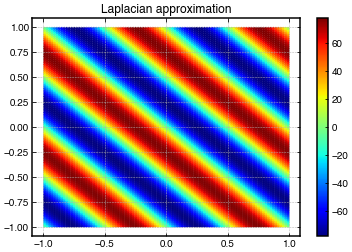

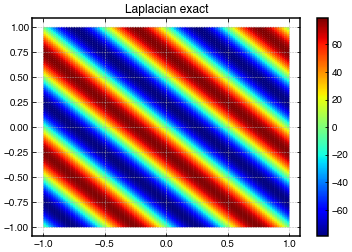

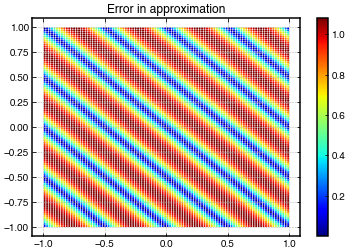

In [8]:
plot(fluid)

In [9]:
dxs = np.array([0.02, 0.01, 0.005, 0.0025, 0.00125])
laplace_error = []
for dx in dxs:
    fluid, lap_err = compute_approximation(dx=dx, perturb=0.0)
    laplace_error.append(lap_err)
print(laplace_error)

[0.6855981975861759, 0.48146715102201926, 0.4302066275745704, 0.41737722499457575, 0.4141689817940048]


In [10]:
laplace_error_pert = []
for dx in dxs:
    perturb = 0.01
    fluid, lap_err = compute_approximation(dx=dx, perturb=perturb)
    laplace_error_pert.append(lap_err)
print(laplace_error_pert)

[0.8904724982563561, 1.1358905381177804, 2.0332255791350593, 3.9188493211488944, 7.768168786946836]


L1 Error in laplacian approximation without perturb:  [0.6855981975861759, 0.48146715102201926, 0.4302066275745704, 0.41737722499457575, 0.4141689817940048]
L1 Error in laplacian approximation with perturb of 0.01 dx:  [0.8904724982563561, 1.1358905381177804, 2.0332255791350593, 3.9188493211488944, 7.768168786946836]


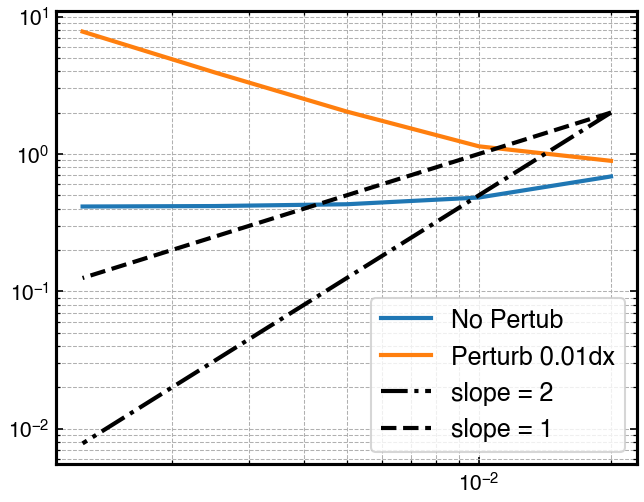

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150)
ax.loglog(dxs, laplace_error, label='No Pertub')
ax.loglog(dxs, laplace_error_pert, label=f'Perturb {perturb}dx')
ax.loglog(dxs, 5000*dxs*dxs, '-.k', label='slope = 2')
ax.loglog(dxs, 100*dxs, '--k', label='slope = 1')
ax.legend()
print("L1 Error in laplacian approximation without perturb: ", laplace_error)
print(f"L1 Error in laplacian approximation with perturb of {perturb} dx: ", laplace_error_pert)